In [1]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        
        if len(token_ids) == max_length:
            input_chunk = token_ids
            target_chunk = token_ids[1:] + [token_ids[-1]]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
        elif len(token_ids) < max_length:
            padded_tokens = token_ids + [0] * (max_length - len(token_ids))
            input_chunk = padded_tokens
            target_chunk = padded_tokens[1:] + [0]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
        else:
            for i in range(0, len(token_ids) - max_length, stride):
                input_chunk = token_ids[i : i + max_length]
                target_chunk = token_ids[i + 1 : i + max_length + 1]
                self.input_ids.append(torch.tensor(input_chunk))
                self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=2, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    
    return dataloader    






In [15]:
import torch.nn as nn
class CausalAttention(nn.Module):
    
    def __init__(self, d_model, dropout=0.1, context_length=2048):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        
        self.w_query = nn.Linear(d_model, d_model, bias=False)
        self.w_key = nn.Linear(d_model, d_model, bias=False)
        self.w_value = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        
        # Register causal mask as buffer (doesn't count as parameter)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, inputs):
        batch_size, seq_len, d_model = inputs.shape
        
        queries = self.w_query(inputs)
        keys = self.w_key(inputs)
        values = self.w_value(inputs)

        attn_scores = queries @ keys.transpose(-2, -1)
        
        # Use only the relevant part of the mask for current sequence length
        mask = self.mask[:seq_len, :seq_len]
        attn_scores = attn_scores.masked_fill(mask == 1, float('-inf'))
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = attn_weights @ values
        return context

# Test the fixed attention
print("Testing fixed CausalAttention...")
test_attention = CausalAttention(d_model=256, context_length=64)
test_input = torch.randn(2, 10, 256)  # batch_size=2, seq_len=10, d_model=256
test_output = test_attention(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print("✓ CausalAttention works correctly with dynamic sequence lengths")

Testing fixed CausalAttention...
Input shape: torch.Size([2, 10, 256])
Output shape: torch.Size([2, 10, 256])
✓ CausalAttention works correctly with dynamic sequence lengths


In [16]:
import torch
import torch.nn as nn

class MultiHeadCausalAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1, context_length=2048):
        super().__init__()
        assert d_model % num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Create attention heads with smaller dimensions
        self.heads = nn.ModuleList([
            CausalAttention(self.head_dim, dropout, context_length) 
            for _ in range(num_heads)
        ])
        
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        batch_size, seq_len, d_model = inputs.shape
        
        # Split input into chunks for each head
        head_inputs = inputs.view(batch_size, seq_len, self.num_heads, self.head_dim)
        head_inputs = head_inputs.transpose(1, 2)  # (batch, heads, seq, head_dim)
        
        # Process each head separately
        head_outputs = []
        for i, head in enumerate(self.heads):
            head_input = head_inputs[:, i, :, :]  # (batch, seq, head_dim)
            head_output = head(head_input)
            head_outputs.append(head_output)
        
        # Concatenate head outputs
        concatenated = torch.cat(head_outputs, dim=-1)  # (batch, seq, d_model)
        
        # Final projection
        output = self.out_proj(concatenated)
        output = self.dropout(output)
        
        return output

# Test the fixed multi-head attention
print("Testing fixed MultiHeadCausalAttention...")
test_mha = MultiHeadCausalAttention(d_model=256, num_heads=4, context_length=64)
test_input_mha = torch.randn(2, 10, 256)
test_output_mha = test_mha(test_input_mha)
print(f"Input shape: {test_input_mha.shape}")
print(f"Output shape: {test_output_mha.shape}")
print("✓ MultiHeadCausalAttention works correctly")

# Test with different sequence lengths
for seq_len in [5, 15, 32]:
    test_input_var = torch.randn(1, seq_len, 256)
    test_output_var = test_mha(test_input_var)
    print(f"Seq len {seq_len}: {test_input_var.shape} -> {test_output_var.shape}")

Testing fixed MultiHeadCausalAttention...
Input shape: torch.Size([2, 10, 256])
Output shape: torch.Size([2, 10, 256])
✓ MultiHeadCausalAttention works correctly
Seq len 5: torch.Size([1, 5, 256]) -> torch.Size([1, 5, 256])
Seq len 15: torch.Size([1, 15, 256]) -> torch.Size([1, 15, 256])
Seq len 32: torch.Size([1, 32, 256]) -> torch.Size([1, 32, 256])


In [19]:
import torch
import torch.nn as nn

class MultiHeadCausalAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1, context_length=2048):
        super().__init__()
        # Implementation of MultiHeadCausalAttention
        # ...

    def forward(self, x):
        # Implementation of forward pass
        # ...
        return x

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1, context_length=2048):
        super().__init__()
        self.attention = MultiHeadCausalAttention(d_model, num_heads, dropout, context_length)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        attn_out = self.attention(x)
        x = self.norm1(x + self.dropout(attn_out))
        
        # Feed forward with residual connection
        ff_out = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_out))
        
        return x

# Test the updated TransformerBlock
print("Testing updated TransformerBlock...")
test_block = TransformerBlock(d_model=256, num_heads=4, d_ff=1024, context_length=64)
test_input_block = torch.randn(2, 10, 256)
test_output_block = test_block(test_input_block)
print(f"Input: {test_input_block.shape} -> Output: {test_output_block.shape}")
print("✓ TransformerBlock updated successfully")

Testing updated TransformerBlock...
Input: torch.Size([2, 10, 256]) -> Output: torch.Size([2, 10, 256])
✓ TransformerBlock updated successfully


In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, context_length, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadCausalAttention(
            d_in=d_model, 
            d_out=d_model, 
            context_length=context_length, 
            dropout=dropout, 
            num_heads=num_heads
        )
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        attn_out = self.attention(x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_out))
        
        return x

In [21]:
class GPTModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, context_length, dropout=0.1):
        super().__init__()
        self.context_length = context_length
        self.d_model = d_model
        
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_embedding = nn.Embedding(context_length, d_model)
        self.dropout = nn.Dropout(dropout)
        
        # Create transformer blocks with proper parameter order
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout, context_length) 
            for _ in range(num_layers)
        ])
        
        self.final_norm = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        
        # Create position indices
        pos_indices = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        
        # Get embeddings
        token_embeds = self.token_embedding(input_ids)
        pos_embeds = self.positional_embedding(pos_indices)
        
        x = token_embeds + pos_embeds
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.final_norm(x)
        logits = self.lm_head(x)
        
        return logits

# Test the corrected GPT model
print("Testing corrected GPT model...")
test_model = GPTModel(
    vocab_size=50257,
    d_model=256,
    num_heads=4,
    num_layers=2,
    d_ff=1024,
    context_length=64,
    dropout=0.1
)

# Test with different sequence lengths
test_inputs = [
    torch.randint(0, 1000, (2, 10)),  # batch=2, seq=10
    torch.randint(0, 1000, (1, 25)),  # batch=1, seq=25
    torch.randint(0, 1000, (3, 5))    # batch=3, seq=5
]

for i, test_input in enumerate(test_inputs):
    try:
        output = test_model(test_input)
        print(f"Test {i+1}: Input {test_input.shape} -> Output {output.shape} ✓")
    except Exception as e:
        print(f"Test {i+1}: Input {test_input.shape} -> Error: {e}")

print("GPT model corrected successfully!")

Testing corrected GPT model...
Test 1: Input torch.Size([2, 10]) -> Output torch.Size([2, 10, 50257]) ✓
Test 2: Input torch.Size([1, 25]) -> Output torch.Size([1, 25, 50257]) ✓
Test 3: Input torch.Size([3, 5]) -> Output torch.Size([3, 5, 50257]) ✓
GPT model corrected successfully!
Test 3: Input torch.Size([3, 5]) -> Output torch.Size([3, 5, 50257]) ✓
GPT model corrected successfully!


In [13]:
raw_text = "Yours journey start"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = tokenizer.encode(raw_text, allowed_special={"<|endoftext|>"})
max_length = len(token_ids)
vocab_size = 50257
output_dim = 3

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(max_length, output_dim)

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=max_length,
    stride=max_length, shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)

token_embeddings = token_embedding_layer(inputs)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))

input_embeddings = token_embeddings + pos_embeddings
input_embeddings[0]




vocab_size = 50257  
d_model = 512       
num_heads = 8       
num_layers = 6      
d_ff = 2048        
context_length = len(token_ids)
dropout = 0.1

model = GPTModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    context_length=context_length,
    dropout=dropout
)


dataloader = create_dataloader_v1(
    raw_text, 
    batch_size=1, 
    max_length=context_length,
    stride=context_length, 
    shuffle=False
)


data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print(f"Input shape: {inputs.shape}")
print(f"Input tokens: {inputs}")
print(f"Target tokens: {targets}")


model.eval()
with torch.no_grad():
    logits = model(inputs)

print(logits)    
print(f"Output logits shape: {logits.shape}")

predictions = torch.argmax(logits, dim=-1)
print(f"Predicted token IDs: {predictions}")

for i, pred_tokens in enumerate(predictions):
    decoded = tokenizer.decode(pred_tokens.tolist())
    print(f"Decoded prediction {i}: '{decoded}'")

Input shape: torch.Size([1, 4])
Input tokens: tensor([[  56, 4662, 7002,  923]])
Target tokens: tensor([[4662, 7002,  923,  923]])
tensor([[[ 1.3864, -0.0533, -0.0948,  ...,  0.8021,  0.6421,  0.0644],
         [-0.0508, -0.1429,  0.7952,  ...,  0.7350,  0.1501,  0.2361],
         [ 1.1689, -0.2618,  0.3253,  ..., -0.0448,  0.7914,  0.7151],
         [ 0.6454,  0.5646,  0.4797,  ..., -1.3333,  0.8063,  0.6064]]])
Output logits shape: torch.Size([1, 4, 50257])
Predicted token IDs: tensor([[47674, 19779, 44010,  9166]])
Decoded prediction 0: ' Particularly {" predicate 71'


## Calculate training validation

In [10]:
def calculate_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calculate_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calculate_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss = calculate_loss_loader(dataloader, model, device)
print(f"Training loss: {train_loss:.4f}")

Training loss: 10.4189


## **Training LLM**

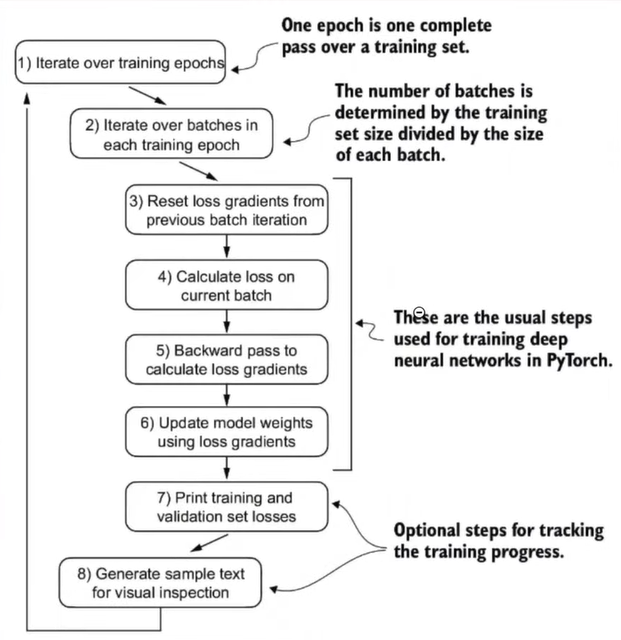

In [31]:
# Simple Training Process Implementation
import torch.optim as optim

def read_file(filename):
    """Read text file and return its contents"""
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        print(f"File '{filename}' not found. Using default text.")
        return """The quick brown fox jumps over the lazy dog. This is a sample text for training our language model. 
We need sufficient text to create multiple batches for proper training. The model will learn to predict the next token 
given the previous tokens in the sequence. Training deep neural networks requires iterating over multiple epochs, 
calculating gradients, and updating model parameters using an optimizer like Adam or SGD. Language models are trained 
to predict the next word in a sequence given the previous words. This is called autoregressive generation. The transformer 
architecture uses self-attention mechanisms to capture long-range dependencies in text. Each attention head learns to 
focus on different aspects of the input sequence. The feed-forward layers provide non-linear transformations. Layer 
normalization helps stabilize training by normalizing activations. Residual connections allow gradients to flow 
through deep networks more easily. Positional encodings give the model information about token positions since 
self-attention is permutation invariant. Training requires careful hyperparameter tuning including learning rates, 
batch sizes, and model dimensions."""

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()  
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
  
            loss = calculate_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            
            optimizer.step()
            
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss = calculate_loss_loader(train_loader, model, device, num_batches=eval_iter)
                val_loss = calculate_loss_loader(val_loader, model, device, num_batches=eval_iter)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
            
        
        model.eval()
        context = torch.tensor([tokenizer.encode(start_context)], device=device)
        
        with torch.no_grad():
            for _ in range(10): 
                logits = model(context)
                logits = logits[:, -1, :] 
                probabilities = torch.softmax(logits, dim=-1)
                next_token = torch.multinomial(probabilities, num_samples=1)
                context = torch.cat([context, next_token], dim=1)
        
        generated_text = tokenizer.decode(context[0].tolist())

    
    return train_losses, val_losses, track_tokens_seen


longer_text = read_file("AI in india.txt")

print(f"Training text length: {len(longer_text)} characters")
print(f"Estimated tokens: {len(tokenizer.encode(longer_text))}")

train_loader = create_dataloader_v1(
    longer_text, 
    batch_size=8,     
    max_length=32,    
    stride=16,       
    shuffle=True
)

val_loader = create_dataloader_v1(
    longer_text, 
    batch_size=8, 
    max_length=32,
    stride=16, 
    shuffle=False
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

vocab_size = 50257  
d_model = 256      
num_heads = 4       
num_layers = 2      
d_ff = 1024        
context_length = 64 
dropout = 0.1

model = GPTModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    context_length=context_length,
    dropout=dropout
)

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)

num_epochs = 3
eval_freq = 5 
eval_iter = 1  
start_context = "The quick"

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter, start_context, tokenizer
)

print("\nTraining completed!")
print(f"Final training loss: {train_losses[-1]:.3f}")
print(f"Final validation loss: {val_losses[-1]:.3f}")
print(f"Total tokens seen: {tokens_seen[-1]}")

Training text length: 20088 characters
Estimated tokens: 3540
Training batches: 27
Validation batches: 27

Training completed!
Final training loss: 5.335
Final validation loss: 5.610
Total tokens seen: 20736


## Test with word

In [34]:
import torch
import torch.nn.functional as F

def generate_text(model, tokenizer, prompt, device, max_tokens=50, temperature=1.0, top_k=None):
    """
    Generate text using the trained model
    
    Args:
        model: Your trained GPT model
        tokenizer: Tokenizer used during training
        prompt: Starting text/prompt
        device: Device to run inference on
        max_tokens: Maximum number of tokens to generate
        temperature: Controls randomness (lower = more focused, higher = more random)
        top_k: If specified, only sample from top-k most likely tokens
    """
    model.eval()
    
    # Encode the prompt
    input_ids = tokenizer.encode(prompt)
    context = torch.tensor([input_ids], device=device)  # Shape: [1, seq_len]
    
    generated_text = prompt
    
    print(f"Prompt: '{prompt}'")
    print(f"Generating {max_tokens} tokens...\n")
    
    with torch.no_grad():
        for i in range(max_tokens):
            # Get model predictions
            logits = model(context)
            
            # Focus on the last token's predictions
            next_token_logits = logits[0, -1, :] / temperature
            
            # Apply top-k filtering if specified
            if top_k is not None:
                top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
                # Set all other logits to negative infinity
                next_token_logits = torch.full_like(next_token_logits, float('-inf'))
                next_token_logits[top_k_indices] = top_k_logits
            
            # Convert to probabilities
            probabilities = F.softmax(next_token_logits, dim=-1)
            
            # Sample the next token
            next_token = torch.multinomial(probabilities, num_samples=1)
            
            # FIX: Reshape next_token to match context dimensions
            next_token = next_token.unsqueeze(0)  # Shape: [1, 1]
            
            # Decode the token to text
            next_word = tokenizer.decode([next_token.item()])
            
            # Add to generated text
            generated_text += next_word
            
            # Print progress
            print(f"Step {i+1:2d}: '{next_word}' -> {generated_text}")
            
            # Update context for next prediction
            context = torch.cat([context, next_token], dim=1)
            
            # Keep context within model's limit
            if context.size(1) > model.context_length:
                context = context[:, -model.context_length:]
            
            # Optional: Stop if we generate an end token or period
            if next_word.strip() == '.' and i > 5:  # Stop after a sentence
                break
    
    return generated_text

def interactive_text_generation(model, tokenizer, device):
    """
    Interactive text generation - keep generating until user stops
    """
    print("=== Interactive Text Generation ===")
    print("Enter a prompt and watch the model generate text!")
    print("Type 'quit' to exit\n")
    
    while True:
        prompt = input("Enter your prompt: ").strip()
        
        if prompt.lower() == 'quit':
            print("Goodbye!")
            break
        
        if not prompt:
            print("Please enter a prompt.\n")
            continue
        
        print("\n" + "-"*50)
        
        # Generate with different settings
        print("🔥 Creative Generation (High Temperature):")
        creative_text = generate_text(model, tokenizer, prompt, device, 
                                    max_tokens=20, temperature=1.2)
        
        print("\n" + "-"*30)
        
        print("🎯 Focused Generation (Low Temperature):")
        focused_text = generate_text(model, tokenizer, prompt, device, 
                                   max_tokens=20, temperature=0.7)
        
        print("\n" + "="*50 + "\n")

def batch_generate_examples(model, tokenizer, device):
    """
    Generate multiple examples with different prompts
    """
    print("=== Batch Text Generation Examples ===\n")
    
    # Different prompts to test
    prompts = [
        "Artificial intelligence will",
        "Machine learning algorithms",
        "Deep neural networks are",
        "Natural language processing can",
        "Computer vision technology",
        "AI models learn by",
        "Reinforcement learning uses",
        "Neural networks consist of",
        "Training data helps",
        "Supervised learning requires"
    ]
    
    for i, prompt in enumerate(prompts, 1):
        print(f"Example {i}:")
        print("="*40)
        
        generated = generate_text(model, tokenizer, prompt, device, 
                                max_tokens=15, temperature=0.8, top_k=10)
        
        print(f"\n✨ Final Result: '{generated}'\n")
        print("-"*60 + "\n")

def continue_story(model, tokenizer, device, story_start, rounds=3):
    """
    Continue a story for multiple rounds
    """
    print("=== Story Continuation ===")
    print(f"Starting story: '{story_start}'\n")
    
    current_story = story_start
    
    for round_num in range(rounds):
        print(f"Round {round_num + 1}:")
        print("-" * 30)
        
        # Generate continuation
        continuation = generate_text(model, tokenizer, current_story, device, 
                                   max_tokens=10, temperature=0.9)
        
        # Extract only the new part
        new_part = continuation[len(current_story):]
        current_story = continuation
        
        print(f"Added: '{new_part}'")
        print(f"Story so far: '{current_story}'\n")
    
    print(f"🏁 Final Story: '{current_story}'")
    return current_story

# Alternative simple generation function if you still have issues
def simple_generate_fixed(model, tokenizer, prompt, device, num_words=10):
    """
    Simple text generation with proper tensor handling
    """
    model.eval()
    
    # Start with the prompt
    input_ids = tokenizer.encode(prompt)
    context = torch.tensor([input_ids], device=device)  # Shape: [1, seq_len]
    
    generated_text = prompt
    
    with torch.no_grad():
        for i in range(num_words):
            # Get next word prediction
            logits = model(context)
            next_token_logits = logits[0, -1, :]
            
            # Pick the most likely next token
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)  # Shape: [1]
            next_token = next_token.unsqueeze(0)  # Shape: [1, 1]
            
            # Convert to text and add
            next_word = tokenizer.decode([next_token.item()])
            generated_text += next_word
            
            print(f"Step {i+1}: '{next_word}' -> {generated_text}")
            
            # Update context
            context = torch.cat([context, next_token], dim=1)
            
            # Keep context size manageable
            if context.size(1) > model.context_length:
                context = context[:, -model.context_length:]
    
    return generated_text

# Main execution
if __name__ == "__main__":
    print("🤖 Text Generation with Your Trained Model!")
    print("="*50)
    
    # Test the simple version first
    print("\n0. Simple Generation Test:")
    try:
        result = simple_generate_fixed(model, tokenizer, "Natural language processing can", device, num_words=5)
        print(f"\n✅ Simple generation works: '{result}'\n")
    except Exception as e:
        print(f"❌ Simple generation failed: {e}\n")
    
    # Simple single generation
    print("\n1. Single Text Generation:")
    try:
        result = generate_text(model, tokenizer, "Natural language processing can", device, 
                              max_tokens=10, temperature=0.8)
        print(f"\n✨ Generated: '{result}'\n")
    except Exception as e:
        print(f"❌ Generation failed: {e}\n")
    
    # Multiple examples (reduced to avoid too much output)
    print("2. Multiple Examples (first 3):")
    try:
        prompts = [
            "Artificial intelligence will",
            "Machine learning algorithms", 
            "Deep neural networks are"
        ]
        
        for i, prompt in enumerate(prompts, 1):
            print(f"Example {i}:")
            print("="*40)
            
            generated = generate_text(model, tokenizer, prompt, device, 
                                    max_tokens=8, temperature=0.8, top_k=10)
            
            print(f"\n✨ Final Result: '{generated}'\n")
            print("-"*60 + "\n")
    except Exception as e:
        print(f"❌ Batch generation failed: {e}\n")

🤖 Text Generation with Your Trained Model!

0. Simple Generation Test:
Step 1: ',' -> Natural language processing can,
Step 2: ' and' -> Natural language processing can, and
Step 3: ' the' -> Natural language processing can, and the
Step 4: ' India' -> Natural language processing can, and the India
Step 5: ',' -> Natural language processing can, and the India,

✅ Simple generation works: 'Natural language processing can, and the India,'


1. Single Text Generation:
Prompt: 'Natural language processing can'
Generating 10 tokens...

Step  1: 'Items' -> Natural language processing canItems
Step  2: ',' -> Natural language processing canItems,
Step  3: ' and' -> Natural language processing canItems, and
Step  4: ' being' -> Natural language processing canItems, and being
Step  5: ' for' -> Natural language processing canItems, and being for
Step  6: ' AI' -> Natural language processing canItems, and being for AI
Step  7: ' needs' -> Natural language processing canItems, and being for AI ne